In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression

sns.set()

In [14]:
df = pd.read_csv('train.csv.zip')

In [15]:
df.head()

,DATE,ATM_ID,CLIENT_OUT
0,2015-01-01,0,91600
1,2015-01-02,0,136500
2,2015-01-03,0,335400
3,2015-01-04,0,379000
4,2015-01-05,0,344100


In [16]:
# df_log = df
# df_log['CLIENT_OUT'] = np.log1p(df_log['CLIENT_OUT'])

## Creating pivot table

In [17]:
df_pivot = pd.pivot_table(df, values='CLIENT_OUT', index='ATM_ID', columns='DATE', margins=True, margins_name='All')

In [18]:
df_pivot.head()

DATE,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,...,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,All
ATM_ID,,,,,,,,,,,,,,,,,,,,,
0,91600,136500,335400,379000,344100,575300,158200,296500,453400,415900,...,543500,501600,538900,387200,591400,160400,195100,732100,629700,438624.425887
2,0,0,0,0,0,0,3000,14700,13300,0,...,13700,4600,27900,33100,33100,0,0,24000,12300,48425.991649
3,1200,2200,12100,18000,700,3000,18600,19900,7400,4100,...,194400,254500,247400,302400,360700,3000,1700,115600,229300,269204.175365
4,188400,223000,382000,459400,306400,199900,259500,190500,317500,331500,...,562400,1042800,642500,830400,756000,117100,0,511000,509000,513868.162839
5,64900,87700,159100,155300,175100,119700,137400,115800,195800,104300,...,411800,339900,264500,440200,362000,0,0,0,0,319809.394572


## Finding changes

## CreatingNewPivotTablePROD

In [19]:
def PlotWithChanges(df, df_zeroes_window, index=0, plot=True):
    df_pivot = pd.pivot_table(df, values='CLIENT_OUT', index='ATM_ID', columns='DATE')
    df_zeroes = FindZeroes(df_pivot, window_size=df_zeroes_window)
    
    zeroes = df_zeroes.loc[index, :].values
        
    if plot:
        plt.figure(figsize=(15, 15))
        plt.plot(df_pivot.loc[index, :].values / df_pivot.loc[index, :].values.mean())

        plt.plot(zeroes)
        plt.show()
    
    return ReturnRangesForChanges(zeroes, df_zeroes_window)

In [20]:
def FindZeroes(df_pivot, window_size):
    return df_pivot.T.rolling(window=window_size).mean().T == 0

def ReturnRangesForChanges(zeroes_list, zeroes_window):
    ranges = []

    start_iter = 0
    live = True

    for i, x in enumerate(zeroes_list):
        if live:
            if x == 1:
                ranges.append([start_iter, i - zeroes_window + 1])
                live = False
        else:
            if x == 0:
                start_iter = i
                live = True

    ranges.append([start_iter, i])
    
    return ranges



def ChangeFirstZeroesToNone(row):
    index = row.nonzero()[0][0]
    row[:index] = None
    return row

In [23]:
def CreatingNewPivotTable_TRAIN_ONLY(df, window_size=15):
    
    ids = np.unique(df.ATM_ID)
    df_pivot = pd.pivot_table(df, values='CLIENT_OUT', index='ATM_ID', columns='DATE')
    
    # remove first zeroes
    df_pivot = df_pivot.apply(ChangeFirstZeroesToNone, axis=1)
    
    
    df_zeroes = FindZeroes(df_pivot, window_size=window_size)
    
    final_pivot = pd.DataFrame(columns=df_pivot.columns)
    
    counter = 0
    for i in ids:
        zeroes = df_zeroes.loc[i, :].values
        ranges = ReturnRangesForChanges(zeroes, window_size)
                
        for index, range_ in enumerate(ranges):
            if range_[1] - range_[0] < 62:
                continue
            
            data = df_pivot.loc[i, :].copy()
            data[:range_[0]] = None
            data[range_[1]:] = None
#             print(range_, counter)
            final_pivot.loc[counter, :] = data
    
            counter += 1
            

    del df_zeroes
    
    
    # from pivot back to long df
    final_df = final_pivot.stack().reset_index()
    del final_pivot
    
    final_df = final_df[['DATE', 'level_0', 0]]
    final_df.columns = df.columns
    
    return final_df

In [56]:
from collections import defaultdict

def CreatingNewPivotTable_TEST(df, window_size=15):
    ids = np.unique(df.ATM_ID)
    df_pivot = pd.pivot_table(df, values='CLIENT_OUT', index='ATM_ID', columns='DATE')
    
    df_pivot = df_pivot.apply(ChangeFirstZeroesToNone, axis=1)
    df_zeroes = FindZeroes(df_pivot, window_size=window_size)
    final_pivot = pd.DataFrame(columns=df_pivot.columns)

    renumerate_dict = {}
    
    columns_size = df_pivot.shape[1]
        
    counter = 0
    for i in ids:
        zeroes = df_zeroes.loc[i, :].values
        ranges = ReturnRangesForChanges(zeroes, window_size)[-1]
            
        renumerate_dict[counter] = i
        
        print(ranges)
        
        data = df_pivot.loc[i, :].copy()
        
        if ranges[1] - ranges[0] < 62:
            
            print(i)
            print(ranges)
            
            if ranges[1] - ranges[0] < 7:
                data[:] = np.mean(df_pivot.loc[i, np.range(ranges[-1][0], ranges[-1][1])].values)
            else:
                for index in range(8, 100):
                    data[-index] = data[-index + 7]        
        
        data[:(ranges[1] - 61)] = None
        data[ranges[1]:] = None
        
        final_pivot.loc[counter, :] = data

        counter += 1


    del df_zeroes
    
    
    # from pivot back to long df
    final_df = final_pivot.stack().reset_index()
    del final_pivot
    
    final_df = final_df[['DATE', 'level_0', 0]]
    final_df.columns = df.columns
    
    final_df.ATM_ID = final_df.ATM_ID.map(renumerate_dict)
    
    return final_df, is_small

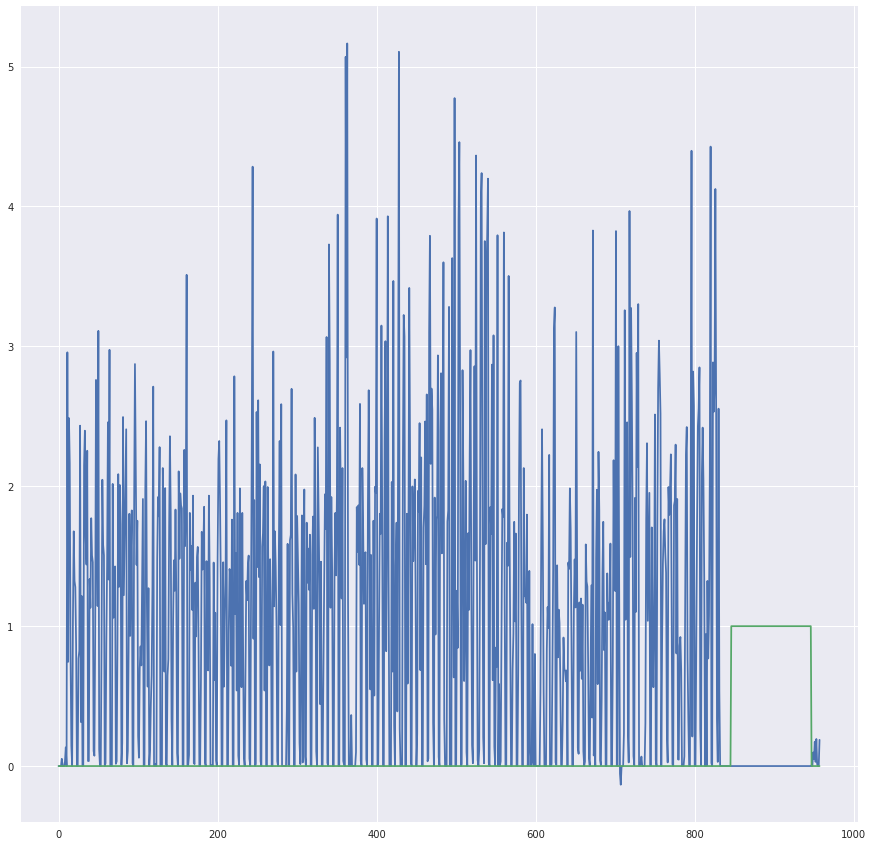

[[0, 832], [947, 957]]

In [57]:
PlotWithChanges(df, 15, 239)

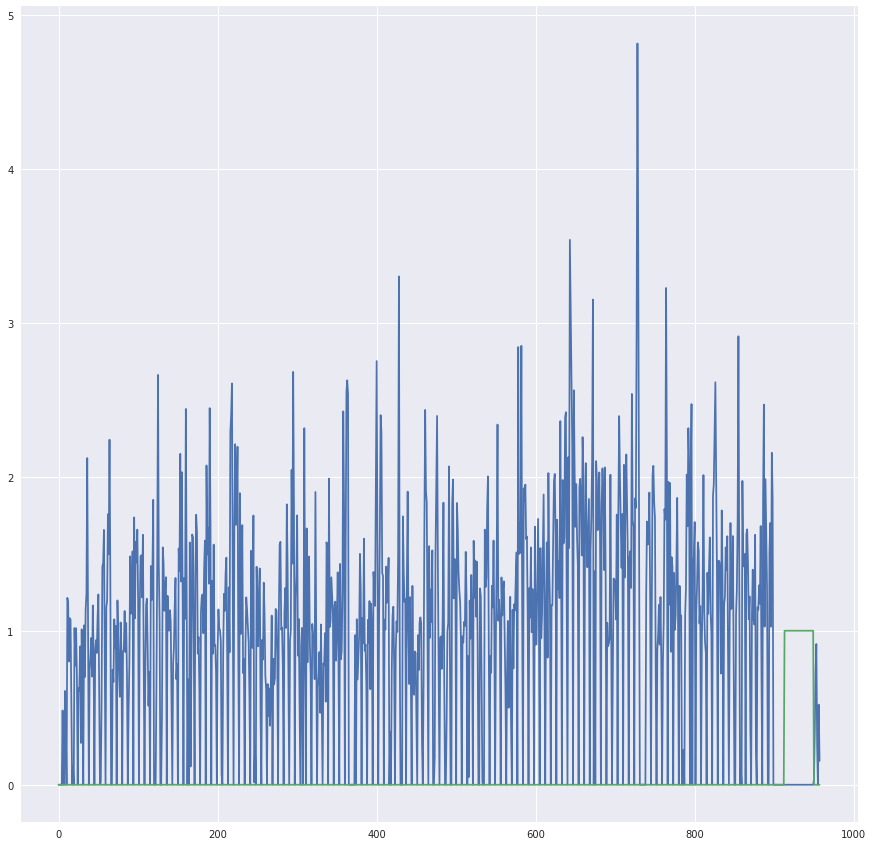

[[0, 899], [950, 957]]

In [11]:
PlotWithChanges(df, 15, 326)

In [58]:
%time
pivot_final_test_NEW, is_small = CreatingNewPivotTable_TEST(df, window_size=15)

CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 20 µs
[0, 957]
[0, 957]
[0, 957]
[638, 957]
[708, 957]
[0, 957]
[0, 957]
[463, 957]
[0, 957]
[918, 957]
10
[918, 957]
[0, 957]
[470, 957]
[775, 957]
[834, 957]
[0, 957]
[862, 957]
[531, 957]
[405, 957]
[607, 957]
[97, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[554, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[728, 957]
[0, 957]
[0, 957]
[0, 957]
[237, 957]
[0, 957]
[70, 957]
[707, 957]
[0, 957]
[0, 957]
[0, 957]
[725, 957]
[413, 957]
[0, 957]
[237, 957]
[588, 957]
[713, 957]
[466, 957]
[729, 957]
[0, 957]
[813, 957]
[0, 957]
[428, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[398, 957]
[0, 957]
[453, 957]
[0, 957]
[509, 957]
[728, 957]
[0, 957]
[0, 957]
[775, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[434, 957]
[816, 957]
[0, 957]
[0, 957]
[0, 957]
[0, 957]
[727, 957]
[0, 957]
[281, 957]
[426, 957]
[426, 957]
[0, 957]
[657, 957]
[510, 957]
[0, 957]
[0, 957]
[565, 957]
[0, 957]
[0, 957]
[0,

In [61]:
pivot_final_test_NEW[pivot_final_test_NEW.ATM_ID == 326]

,DATE,ATM_ID,CLIENT_OUT
14396,2017-06-15,326,362600
14397,2017-06-16,326,451000
14398,2017-06-17,326,125900
14399,2017-06-18,326,0
14400,2017-06-19,326,256600
14401,2017-06-20,326,76500
14402,2017-06-21,326,171300
14403,2017-06-22,326,362600
14404,2017-06-23,326,451000
14405,2017-06-24,326,125900


In [25]:
%time
pivot_final_test, is_small = CreatingNewPivotTable_TEST(df, window_size=15)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs
239 [[0, 832], [947, 957]]
326 [[0, 899], [950, 957]]


In [26]:
is_small

defaultdict(<function __main__.CreatingNewPivotTable_TEST.<locals>.<lambda>>,
            {239: True, 326: True})

In [27]:
pivot_final_test[pivot_final_test.ATM_ID == 239]

,DATE,ATM_ID,CLIENT_OUT
120687,2015-01-05,239,2600
120688,2015-01-06,239,0
120689,2015-01-07,239,0
120690,2015-01-08,239,0
120691,2015-01-09,239,1700
120692,2015-01-10,239,6700
120693,2015-01-11,239,0
120694,2015-01-12,239,148400
120695,2015-01-13,239,37400
120696,2015-01-14,239,124800


In [ ]:
%time
pivot_final = CreatingNewPivotTable_TRAIN_ONLY(df, window_size=15)

In [ ]:
pivot_final

In [ ]:
pivot_final.fillna(0, inplace=True)

In [ ]:
plt.plot(pivot_final.loc[3, :].values)
plt.show()

In [ ]:
for x in range(10):
    plt.plot(pivot_final.loc[x, :].values)
    plt.show()

In [ ]:
PlotWithChanges(5, plot=False)

## Changes hardcoded first 60 only

In [ ]:
for i in ids:
    df_pivot.loc[i, 'changes_new'] = len(PlotWithChanges(i, plot=False))

In [ ]:
len(PlotWithChanges(0))

In [ ]:
indices_where_algorith_was_wrong = df_pivot[:50][df_pivot.changes != df_pivot.changes_new].index

In [ ]:
indices_where_algorith_was_wrong

In [ ]:
PlotWithChanges(8)

In [ ]:
# for i in indices_where_algorith_was_wrong:
#     print(i)
#     PlotWithChanges(i)

In [ ]:
changes_dict = {
    4 : 1,
    8 : 1,
    10 : 2,
    17 : 2,
    18 : 1,
    21 : 1,
    22 : 1,
    23 : 1,
    24 : 1,
    32 : 1,
    44 : 1,
    48 : 2,
    52 : 2,
    55 : 2,
    56 : 1,
    57 : 1,
    60 : 1,
}

In [ ]:
df_pivot['changes'] = 1

In [ ]:
for key, value in changes_dict.items():
    df_pivot.loc[key, 'changes'] = value + 1

## Plots

In [ ]:
for x in indeces_where_algorith_was_wrong:
    plt.figure(figsize=(15,10))
    plt.title('ATM_ID {0}'.format(x))
    data = df[df.ATM_ID==x].CLIENT_OUT
    plt.plot(range(len(data)), data)
    plt.show()